In this notebook, we obtain the proability distribution of $D_{\rm s}/D_{\rm ds}$ corresponding to WGD2038-4008's redshifts using the relative distances constrained by the Pantheon dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import paperfig as pf

pf.set_fontscale(2.)

## Load the Pantheon dataset

In [2]:
import pandas as pd

sn_data = np.genfromtxt('../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_lcparam-full.txt', usecols=(1, 2, 3, 4, 5))
sn_error_mat = np.genfromtxt('../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_sys-full.txt').reshape(1048, -1)

In [3]:
inv_cov = np.linalg.inv( np.diag(sn_data[:, 4]**2) + sn_error_mat**2)

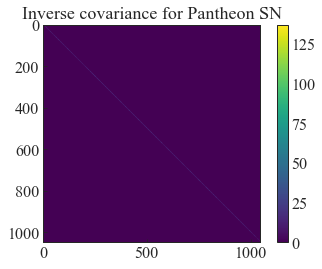

In [4]:
cax = plt.imshow(inv_cov, cmap='viridis') #vmax=0.001, vmin=-0.001)
plt.title('Inverse covariance for Pantheon SN')
plt.colorbar()

In [5]:
df = pd.DataFrame(sn_data)

df.head()

,0,1,2,3,4
0,0.50309,0.50309,0.0,22.93445,0.12605
1,0.49480,0.49480,0.0,22.88020,0.11765
2,0.67767,0.67767,0.0,24.03770,0.20560
3,0.86650,0.86650,0.0,24.34685,0.17385
4,0.79857,0.79857,0.0,24.36050,0.17435


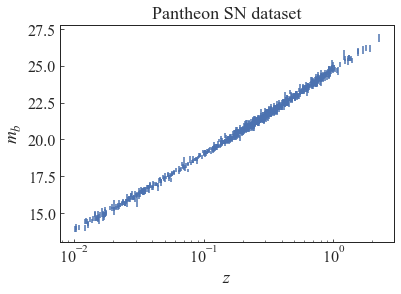

In [6]:
plt.errorbar(df[0], df[3], yerr=df[4], ls='None')
plt.title('Pantheon SN dataset')
plt.xlabel(r'$z$')
plt.ylabel(r'$m_{b}$')
plt.xscale('log')

In [7]:
def get_mb_from_params(params, zs):
    """
    Compute SN apparent magnitude from cosmological model params and redsfhits. Use SN absolute mag = 19.3.
    """
    D_L = get_DL_from_params(params, zs) # in Gpc
    
    mb = 5 * np.log10(D_L*1e9) - 19.3 - 5.
    
    return mb


def get_DL_from_params(params, zs):
    """
    Compute the luminosity distance D_L from cosmological model params. We use the Taylor expansion-based params,
    e.g., H_0, q_0, j_0,... to express the distance as a polynomial of z.
    """
    if len(np.array(params).shape) > 1:
        num_params = params.shape[1]
        
        H0 = params[:, 0]
        q0 = params[:, 1]
        if num_params > 2:
            j0 = params[:, 2]
        else:
            j0 = 0.
        if num_params > 3:
            s0 = params[:, 3]
        else:
            s0 = 0.
        if num_params > 4:
            omega_k = params[:, 4]
        else:
            omega_k = 0.
    else:
        num_params = len(params)
        
        H0 = params[0]
        q0 = params[1]
        if num_params > 2:
            j0 = params[2]
        else:
            j0 = 0.
        if num_params > 3:
            s0 = params[3]
        else:
            s0 = 0.
        if num_params > 4:
            omega_k = params[4]
        else:
            omega_k = 0.
    
    d2 = (1. - q0) / 2.
    d3 = - (1. + j0 - omega_k - q0 - 3.*q0**2) / 6.
    d4 = (2. + s0 + 5.*j0 - 2.*omega_k - 2.*q0 + 10.*j0*q0 
          - 6.*omega_k*q0 - 15.*q0*q0 - 15.*q0**3) / 24.
    
    cH0 = 299792.458 / H0 / 1e3
    
    DL = cH0 * (zs + d2*zs**2 + d3*zs**3 + d4*zs**4)
    
    DL[DL<=0.] = 1e-15
    
    return DL


def get_DA_from_params(params, zs):
    """
    Compute angular diameter distance for redshift `zs` given cosmological model parameters.
    """
    return get_DL_from_params(params, zs) / (1. + zs)**2

In [8]:
def log_likelihood(params):
    """
    Compute the likelihood of the Pantheon dataset.
    """ 
    if params[0] < 0:
        return -1e15
    
    model = get_mb_from_params(params, sn_data[:, 0])
    
    if np.any(np.isnan(model)):
        return -1e15
        
    delta = sn_data[:, 3] - model
    
    log_L = -0.5 * (delta.T @ (inv_cov @ delta))
  
    if np.isnan(log_L) or np.isinf(log_L):
        return -1.e15
    
    return log_L

In [9]:
# just checking the output of the likelihood function
log_likelihood([67., -0.47, 0.24, 1., 1.2])

-2078.818641186522

In [10]:
import dynesty


def prior_transform(u):
    """
    Transform our unit cube samples `u` to a flat prior in each variable.
    """
    n = len(u)
    
    center = np.array([70.0,  0.,  0.,  0., 0.])[:n]
    
    width = np.array([50., 20., 20., 20., 20])[:n] 
    
    return width * (2. * u - 1.) + center

## Compute model evidence for different order of polynomial expressions for distance D using nested sampling

In [11]:
results = []

for ndim in [2, 3, 4, 5]:
    sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim, 
                                    nlive=2000
                                   )

    sampler.run_nested(dlogz=0.01, 
                       #nlive_init=50, maxbatch=2,
                       #maxiter=res.niter+res.nlive, use_stop=False, 
                       #wt_kwargs={'pfrac': .8}
                      )

    # grab the results
    res = sampler.results

    print('num params: # {}'.format(ndim))
    res.summary()
    
    results.append(res)

iter: 33588 | +2000 | bound: 20 | nc: 1 | ncall: 129360 | eff(%): 27.511 | loglstar:   -inf < -543.043 <    inf | logz: -555.223 +/-  0.106 | dlogz:  0.000 >  0.010                                  

num params: # 2
Summary
nlive: 2000
niter: 33588
ncall: 129360
eff(%): 27.511
logz: -555.223 +/-  0.106


iter: 44212 | +2000 | bound: 46 | nc: 1 | ncall: 206975 | eff(%): 22.327 | loglstar:   -inf < -516.863 <    inf | logz: -534.353 +/-  0.126 | dlogz:  0.000 >  0.010                                  

num params: # 3
Summary
nlive: 2000
niter: 44212
ncall: 206975
eff(%): 22.327
logz: -534.353 +/-  0.126


iter: 47329 | +2000 | bound: 71 | nc: 1 | ncall: 282573 | eff(%): 17.457 | loglstar:   -inf < -516.165 <    inf | logz: -535.214 +/-  0.131 | dlogz:  0.000 >  0.010                                  

num params: # 4
Summary
nlive: 2000
niter: 47329
ncall: 282573
eff(%): 17.457
logz: -535.214 +/-  0.131


iter: 46809 | +2000 | bound: 67 | nc: 1 | ncall: 269914 | eff(%): 18.083 | loglstar:   -inf < -516.165 <    inf | logz: -534.954 +/-  0.130 | dlogz:  0.000 >  0.010                                  

num params: # 5
Summary
nlive: 2000
niter: 46809
ncall: 269914
eff(%): 18.083
logz: -534.954 +/-  0.130


## Choose the model with the highest evidence

In [12]:
logzs = []

for res in results:
    logzs.append(res.logz[-1])
    
ndim = np.argmax(logzs) + 2 # choose ndim with highest evidence

print('Number of parameters in highest-evidence model: {}'.format(ndim))

Number of parameters in highest-evidence model: 3


### Some diagnostic plots of nested sampling

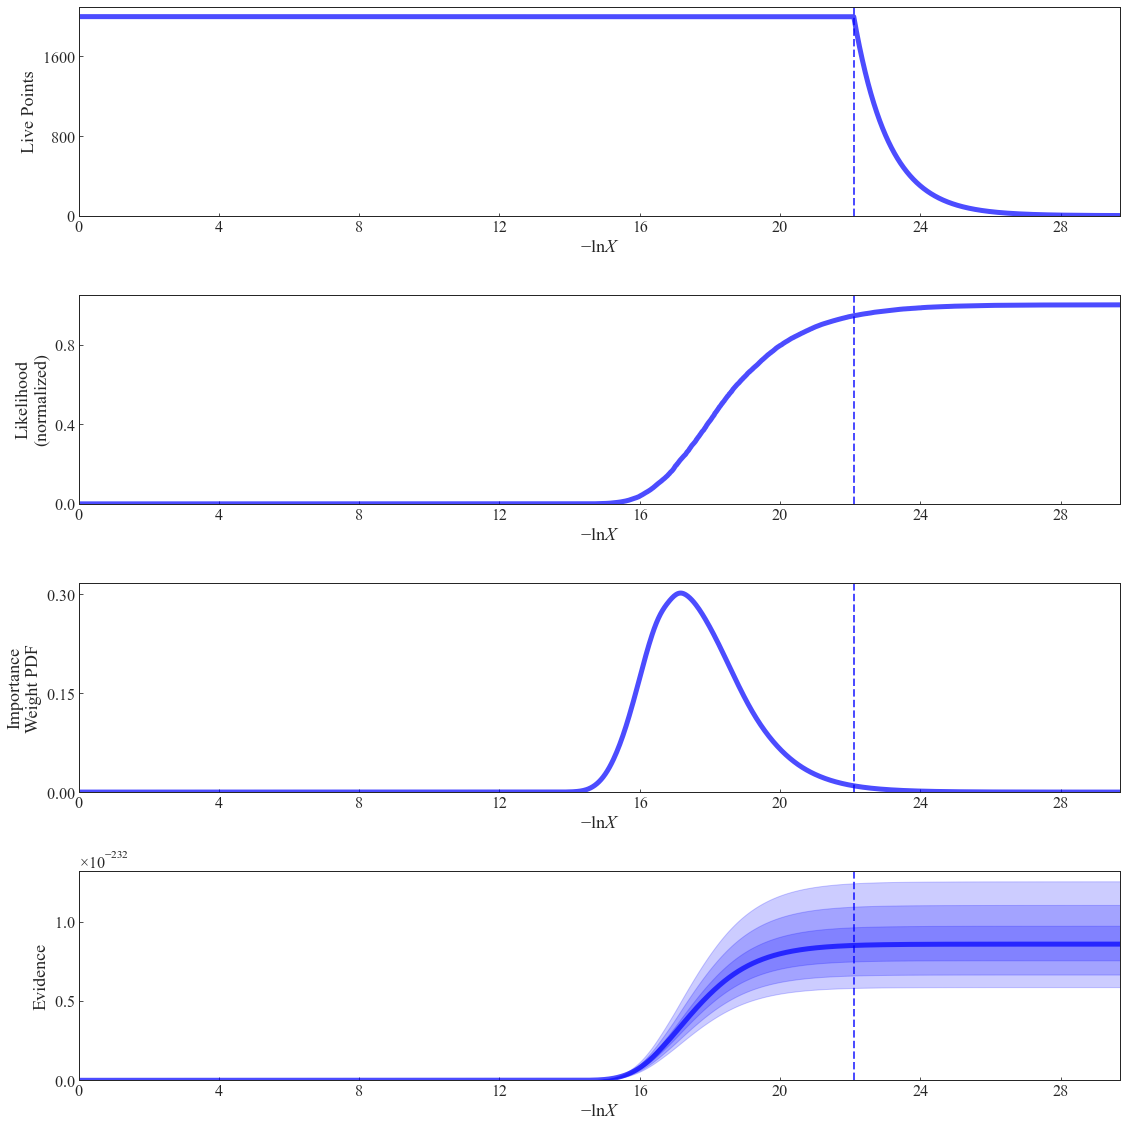

In [13]:
from dynesty import plotting as dyplot

lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(results[ndim-2], lnz_truth=lnz_truth)
fig.tight_layout()

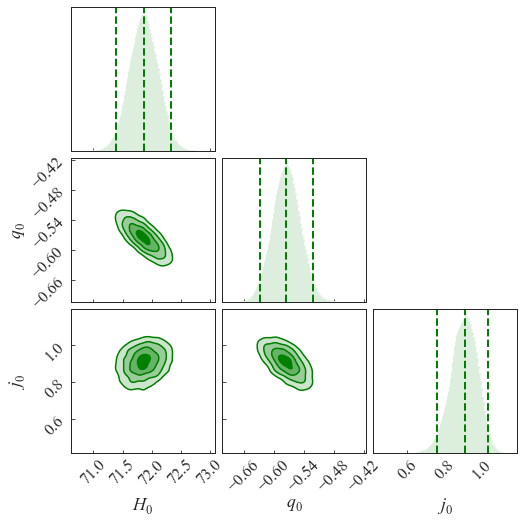

In [14]:
n_params = ndim
fg, ax = dyplot.cornerplot(results[ndim-2], color='green', #truths=np.zeros(ndim),
                           labels=[r'$H_0$', r'$q_0$', r'$j_0$', r'$s_0$', r'$\Omega_{k}$'], #[:n_params]
                           #span=[(-4.5, 4.5) for i in range(ndim)],
                           #show_titles=True, title_kwargs={'y': 1.05},
                           #quantiles=None, fig=(fig, axes[:, :3])
                          )

plt.show()

### The nested-sampling samples need to be resampled to have equal weights.

In [15]:
samples = results[ndim-2].samples
weights = results[ndim-2].logwt

In [16]:
equal_weight_samples = dynesty.utils.resample_equal(samples, np.exp(weights)/np.sum(np.exp(weights)))

## Illustrate cosmological distances from the best fitting model

The plots show absolute distances, and they use the absolute magnitude for type Ia supernova to be $M_{\rm SNIa} = 19.3$. This is only used for illustration to check the best-fit models, and it does not impact the distance ratios.

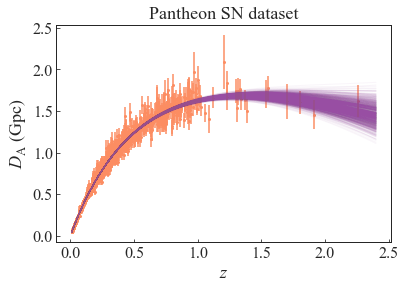

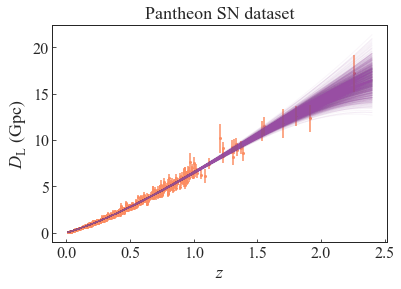

In [17]:
zs = np.linspace(0.01, 2.4, 100)


def mb_to_DA(mb):
    """
    Get angular diameter distance in Gpc. Use 19.3 as SNIa absolute magnitude (only for illustration, 
    does not impact the distance ratio distribution).
    """
    return 10**((mb + 19.3 + 5)/5.) / 1e9


plt.errorbar(df[1], mb_to_DA(df[3])/(1+df[1])**2,
         yerr=(mb_to_DA(df[3]+df[4])/(1+df[1])**2 - mb_to_DA(df[3]-df[4])/(1+df[1])**2)/2.,
         ls='None', marker='o', markersize=2, color=pf.cb2_orange)

for i in np.random.randint(low=0, high=len(equal_weight_samples), size=1000):
    param_array = equal_weight_samples[i]
    plt.plot(zs, get_DA_from_params(param_array, zs), zorder=10., lw=1., alpha=0.05,
             color=pf.cb_purple)
    
    
plt.title('Pantheon SN dataset')
plt.xlabel(r'$z$')
plt.ylabel(r'$D_{\rm A}$ (Gpc)')
#plt.xscale('log')
plt.show()

plt.errorbar(df[1], mb_to_DA(df[3]),
         yerr=(mb_to_DA(df[3]+df[4]) - mb_to_DA(df[3]-df[4]))/2.,
         ls='None', marker='o', markersize=2, color=pf.cb2_orange)

for i in np.random.randint(low=0, high=len(equal_weight_samples), size=1000):
    param_array = equal_weight_samples[i]
    plt.plot(zs, get_DL_from_params(param_array, zs), zorder=10., lw=1., alpha=0.05, color=pf.cb_purple)

plt.title('Pantheon SN dataset')
plt.xlabel(r'$z$')
plt.ylabel(r'$D_{\rm L}$ (Gpc)');
#plt.xscale('log')

In [18]:
z_l = 0.230
z_s = 0.777

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


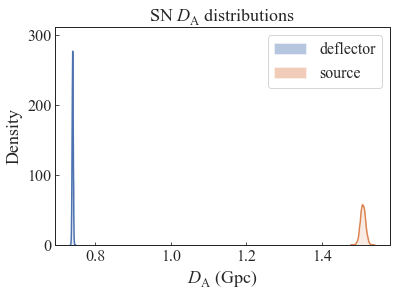

In [19]:
sn_DA_l = get_DA_from_params(equal_weight_samples, z_l)
sn_DA_s = get_DA_from_params(equal_weight_samples, z_s)

import seaborn as sns

sns.distplot(sn_DA_l, label='deflector')
sns.distplot(sn_DA_s, label='source')

plt.title('SN $D_{\\rm A}$ distributions')
plt.legend()
#plt.xlim(1, 2);
plt.xlabel(r'$D_{\rm A}$ (Gpc)');
#mb_s1

## Obtain distance ratio distribution

In [20]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u


def get_DA_cosmo(omega_m, z2, z1=0):
    Ds = np.zeros_like(omega_m)
    
    for i, om in enumerate(omega_m):
        cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=om)
        
        if z1 == 0:
            Ds[i] = cosmo.angular_diameter_distance(z2).value
        else:
            Ds[i] = cosmo.angular_diameter_distance_z1z2(z1, z2).value
    
    return Ds

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


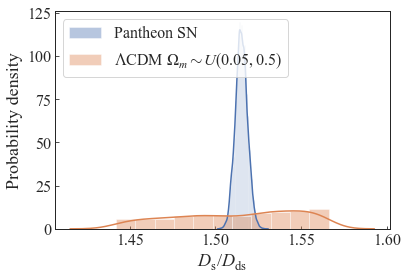

In [21]:
sn_Dsds = sn_DA_s / (sn_DA_s - sn_DA_l * (1 + z_l) / (1 + z_s))

omega_ms = np.random.uniform(0.05, 0.5, 1000)

D_s = get_DA_cosmo(omega_ms, z_s)
D_ds = get_DA_cosmo(omega_ms, z_s, z_l)

sns.distplot(sn_Dsds, label='Pantheon SN')
sns.distplot(D_s/D_ds, label=r'$\Lambda$CDM $\Omega_m \sim U(0.05, 0.5)$')
plt.legend(loc='upper left');
plt.xlabel(r'$D_{\rm s}/D_{\rm ds}$')
plt.ylabel('Probability density');
#plt.savefig()

In [22]:
#np.savetxt('Pantheon_D_sds_distribution.txt', sn_Dsds)